In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import pandas as pd
%matplotlib inline

In [3]:
nodes_file = "Department_Collaborate_node.csv"
nodes_df = pd.read_csv(nodes_file, header=None, names=["id", "label"])

In [4]:
G = nx.Graph()

for _, row in nodes_df.iterrows():
    G.add_node(row['id'], label=row['label'])

In [5]:
print("Nodes:", G.nodes(data=True))

Nodes: [(1, {'label': 'PlanBudge'}), (2, {'label': 'Audit'}), (3, {'label': 'PublicRelation'}), (4, {'label': 'JobEconomy'}), (5, {'label': 'FutureStrategy'}), (6, {'label': 'EnergyNewIndustry'}), (7, {'label': 'EducationSupport'}), (8, {'label': 'AthleticsPromotion'}), (9, {'label': 'Tourism'}), (10, {'label': 'ArtCulture'}), (11, {'label': 'EnvironmentManagement'}), (12, {'label': 'CityBeautification'}), (13, {'label': 'ParkGreenspace'}), (14, {'label': 'CultureArtSpecializePlanUnit'}), (15, {'label': 'Construction'}), (16, {'label': 'SafetyDisaster'}), (17, {'label': 'City'}), (18, {'label': 'TransportationAdmin'}), (19, {'label': 'BuildinPpermit'}), (20, {'label': 'WaterSewer'}), (21, {'label': 'YeongsanpoDevelopPlanOrganization'}), (22, {'label': 'Secretary'}), (23, {'label': 'ResidentAssistance'}), (24, {'label': 'SocialService'}), (25, {'label': 'Taxation'}), (26, {'label': 'Accounting'}), (27, {'label': 'CivicService'}), (28, {'label': 'AgriculturePolicy'}), (29, {'label': 'Hor

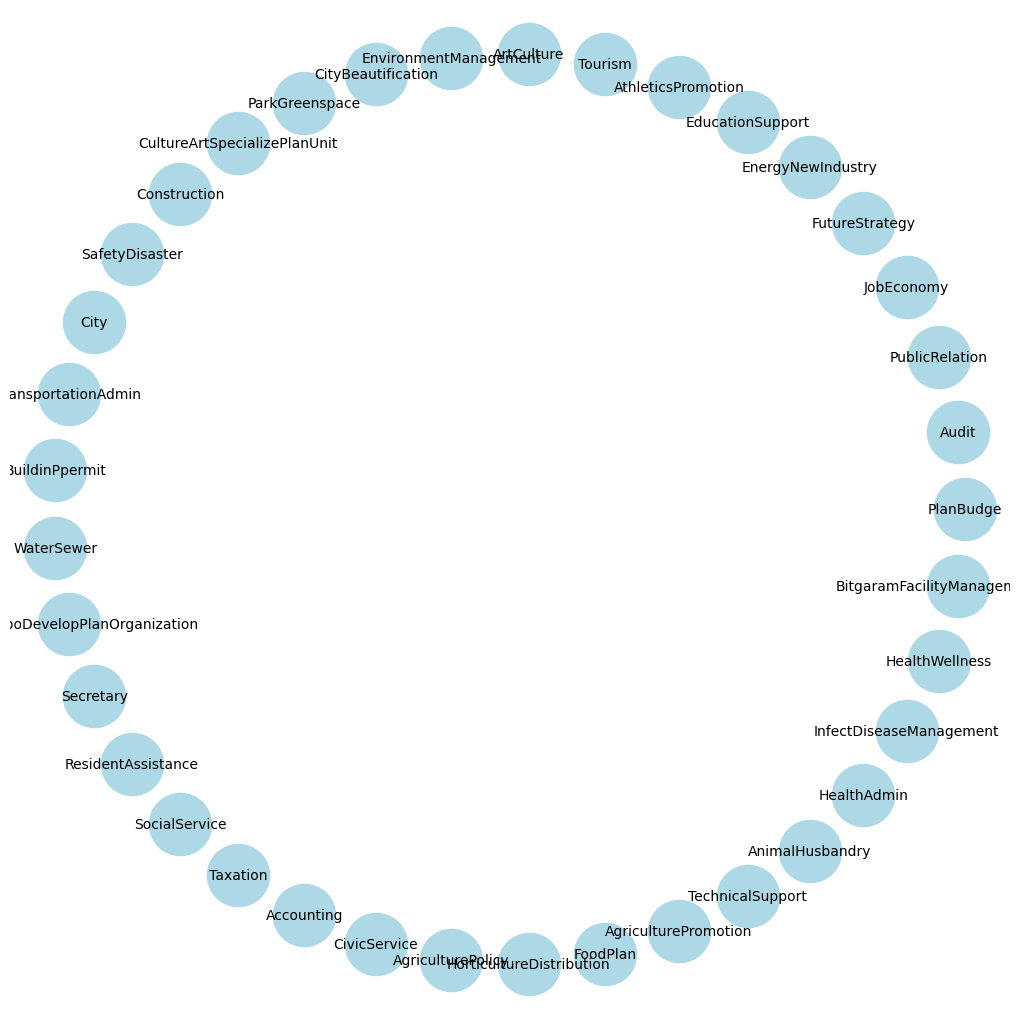

In [ ]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=3.0, iterations=100)
# pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), 
        node_size=2000, node_color="lightblue", font_size=10, font_color="black")
# plt.title("Network Visualization", fontsize=16)
plt.show()